In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
import keras


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
dataset = pd.read_csv("D:\Sem 7\ML\m_Train.csv")
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
dataset.shape

(1490, 3)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [5]:
dataset['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [6]:
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [7]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [8]:
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


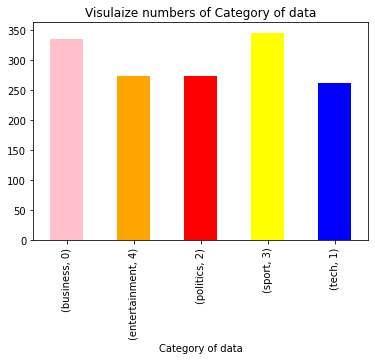

In [9]:
dataset.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

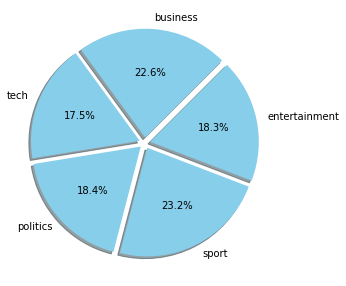

In [10]:
fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
business = dataset[dataset['CategoryId'] == 0 ]
tech = dataset[dataset['CategoryId'] == 1 ]
politics = dataset[dataset['CategoryId'] == 2]
sport = dataset[dataset['CategoryId'] == 3]
entertainment = dataset[dataset['CategoryId'] == 4]
count = [business['CategoryId'].count(), tech['CategoryId'].count(), politics['CategoryId'].count(), sport['CategoryId'].count(), entertainment['CategoryId'].count()]
pie = plt.pie(count, labels = ['business', 'tech', 'politics', 'sport', 'entertainment'],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 45,
              explode = (0.05, 0.05, 0.05, 0.05,0.05))

In [11]:
text = dataset["Text"]
text.head(10)

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
5    howard  truanted to play snooker  conservative...
6    wales silent on grand slam talk rhys williams ...
7    french honour for director parker british film...
8    car giant hit by mercedes slump a slump in pro...
9    fockers fuel festive film chart comedy meet th...
Name: Text, dtype: object

In [12]:
category = dataset['Category']
category.head(10)

0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
Name: Category, dtype: object

In [13]:
def remove_tags(text):
  remove = re.compile(r'')
  return re.sub(remove, '', text)
dataset['Text'] = dataset['Text'].apply(remove_tags)

In [14]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews
dataset['Text'] = dataset['Text'].apply(special_char)

In [15]:
def convert_lower(text):
   return text.lower()
dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [16]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]
dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][1]


['german',
 'business',
 'confidence',
 'slides',
 'german',
 'business',
 'confidence',
 'fell',
 'february',
 'knocking',
 'hopes',
 'speedy',
 'recovery',
 'europe',
 'largest',
 'economy',
 'munich',
 'based',
 'research',
 'institute',
 'ifo',
 'said',
 'confidence',
 'index',
 'fell',
 '95',
 '5',
 'february',
 '97',
 '5',
 'january',
 'first',
 'decline',
 'three',
 'months',
 'study',
 'found',
 'outlook',
 'manufacturing',
 'retail',
 'sectors',
 'worsened',
 'observers',
 'hoping',
 'confident',
 'business',
 'sector',
 'would',
 'signal',
 'economic',
 'activity',
 'picking',
 'surprised',
 'ifo',
 'index',
 'taken',
 'knock',
 'said',
 'dz',
 'bank',
 'economist',
 'bernd',
 'weidensteiner',
 'main',
 'reason',
 'probably',
 'domestic',
 'economy',
 'still',
 'weak',
 'particularly',
 'retail',
 'trade',
 'economy',
 'labour',
 'minister',
 'wolfgang',
 'clement',
 'called',
 'dip',
 'february',
 'ifo',
 'confidence',
 'figure',
 'mild',
 'decline',
 'said',
 'despite',
 'r

In [17]:
dataset

,ArticleId,Text,Category,CategoryId
0,1833,"[worldcom, ex, boss, launches, defence, lawyer...",business,0
1,154,"[german, business, confidence, slides, german,...",business,0
2,1101,"[bbc, poll, indicates, economic, gloom, citize...",business,0
3,1976,"[lifestyle, governs, mobile, choice, faster, b...",tech,1
4,917,"[enron, bosses, 168m, payout, eighteen, former...",business,0
...,...,...,...,...
1485,857,"[double, eviction, big, brother, model, capric...",entertainment,4
1486,325,"[dj, double, act, revamp, chart, show, dj, duo...",entertainment,4
1487,1590,"[weak, dollar, hits, reuters, revenues, media,...",business,0
1488,1587,"[apple, ipod, family, expands, market, apple, ...",tech,1


In [18]:
nltk.download('omw-1.4')

[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [19]:
def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])
dataset['Text'] = dataset['Text'].apply(lemmatize_word)
dataset['Text'][1]

'german business confidence slide german business confidence fell february knocking hope speedy recovery europe largest economy munich based research institute ifo said confidence index fell 95 5 february 97 5 january first decline three month study found outlook manufacturing retail sector worsened observer hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew 1 6 last year shrinking 2003 however economy contracted 0 2 last three month 2004 mainly due reluctance consumer spend latest indication growth still proving elusive ifo president han werner sinn said improvement german domestic demand sluggish export

In [20]:
dataset

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex bos launch defence lawyer defendin...,business,0
1,154,german business confidence slide german busine...,business,0
2,1101,bbc poll indicates economic gloom citizen majo...,business,0
3,1976,lifestyle governs mobile choice faster better ...,tech,1
4,917,enron boss 168m payout eighteen former enron d...,business,0
...,...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment,4
1487,1590,weak dollar hit reuters revenue medium group r...,business,0
1488,1587,apple ipod family expands market apple expande...,tech,1


In [21]:
x = dataset['Text']
y = dataset['CategoryId']

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset.Text).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 5000)
y.shape =  (1490,)


In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train))
print(len(x_test))
perform_list = [ ]

1043
447


In [24]:

def run_model(model_name, est_c, est_pnlty):

 mdl=''

 if model_name == 'Logistic Regression':

  mdl = LogisticRegression()

 elif model_name == 'Random Forest':

  mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)

 elif model_name == 'Multinomial Naive Bayes':

  mdl = MultinomialNB(alpha=1.0,fit_prior=True)

 elif model_name == 'Support Vector Classifer':

  mdl = SVC()

 elif model_name == 'Decision Tree Classifier':

  mdl = DecisionTreeClassifier()

 elif model_name == 'K Nearest Neighbour':

  mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)

 elif model_name == 'Gaussian Naive Bayes':

  mdl = GaussianNB()
 
 oneVsRest = OneVsRestClassifier(mdl)

 oneVsRest.fit(x_train, y_train)
 y_pred = oneVsRest.predict(x_test)

 accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

 
 precision, recall, f1score, support = score(y_test, y_pred, average='micro')

 print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
 
 print(f'Precision : {precision}')

 print(f'Recall : {recall}')

 print(f'F1-score : {f1score}')

 perform_list.append(dict([

   ('Model', model_name),

   ('Test Accuracy', round(accuracy, 2)),

   ('Precision', round(precision, 2)),

   ('Recall', round(recall, 2)),

   ('F1', round(f1score, 2))

  ]))

In [25]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 97.09
Precision : 0.970917225950783
Recall : 0.970917225950783
F1-score : 0.9709172259507831


In [26]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 97.99
Precision : 0.9798657718120806
Recall : 0.9798657718120806
F1-score : 0.9798657718120806


In [27]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.09
Precision : 0.970917225950783
Recall : 0.970917225950783
F1-score : 0.9709172259507831


In [28]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Support Vector Classifer: % 96.64
Precision : 0.9664429530201343
Recall : 0.9664429530201343
F1-score : 0.9664429530201343


In [29]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Decision Tree Classifier: % 82.1
Precision : 0.8210290827740492
Recall : 0.8210290827740492
F1-score : 0.8210290827740493


In [30]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,97.09,0.97,0.97,0.97
1,Random Forest,97.99,0.98,0.98,0.98
2,Multinomial Naive Bayes,97.09,0.97,0.97,0.97
3,Support Vector Classifer,96.64,0.97,0.97,0.97
4,Decision Tree Classifier,82.10,0.82,0.82,0.82


In [31]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
# position=model_performance.idxmax()
print("The best accuracy of model is", max_value,"from",model)

The best accuracy of model is 97.99 from 0         Logistic Regression
1               Random Forest
2     Multinomial Naive Bayes
3    Support Vector Classifer
4    Decision Tree Classifier
Name: Model, dtype: object


In [32]:
df = pd.DataFrame(model_performance) 
print(df)

                      Model  Test Accuracy  Precision  Recall    F1
0       Logistic Regression          97.09       0.97    0.97  0.97
1             Random Forest          97.99       0.98    0.98  0.98
2   Multinomial Naive Bayes          97.09       0.97    0.97  0.97
3  Support Vector Classifer          96.64       0.97    0.97  0.97
4  Decision Tree Classifier          82.10       0.82    0.82  0.82


In [57]:
classifier = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0).fit(x_train, y_train)
classifier
y_pred = classifier.predict(x_test)
input1=' iran jails blogger for 14 years an by handing down this harsh sentence against a weblogger  their aim is to dissuade journalists and internet-users from expressing themselves online or contacting foreign media.  in the days before his arrest mr sigarchi gave interviews to the bbc persian service and the us-funded radio farda. iranian authorities have arrested about 20 online journalists during the current crackdown. they accused mr sigarchi of a string of crimes against iranian state  including espionage  insulting the founder of iran s islamic republic  ayatollah ruhollah khomenei  and current supreme leader ayatollah ali khamenei. mr sigarchi s lawyer labelled the revolutionary court  illegal and incompetent  and called for a retrial in a public court.  mr sigarchi was sentenced one day after an online campaign highlighted his case in a day of action in defence of bloggers around the world.  the committee to protect bloggers designated 22 february 2005 as free mojtaba and arash day. around 10 000 people visited the campaign s website during the day. about 12% of users were based in iran  the campaign s director told the bbc news website. curt hopkins said mr sigarchi s sentence would not dent the resolve of bloggers joining the campaign to help highlight the case.  the eyes of 8 million bloggers are going to be more focused on iran since sigarchi s sentence  not less.  the mullahs won t be able to make a move without it be spread across the blogosphere.'
y_pred = cv.transform([input1])
yy = classifier.predict(y_pred)
result = ""
if yy == [0]:
  result = "Business News"
elif yy == [1]:
  result = "Tech News"
elif yy == [2]:
  result = "Politics News"
elif yy == [3]:
  result = "Sports News"
elif yy == [4]:
  result = "Entertainment News"
print(result)

Tech News


In [34]:
# from tensorflow.keras.models import load_model
# # model.save('model_resnet50.h5')
# keras.save_model(format='h5')




